In [ ]:
# filtering with waveform width did not make population summary data nicer. Only noiser

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import scipy as sp
import os, sys,glob, copy
import pandas as pd
import h5py
from scipy.ndimage.filters import gaussian_filter

import scipy.sparse

import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline



In [4]:
def FF_index(n_pos, n_neg):
    return (n_pos-n_neg)/float((n_pos+n_neg))
        
from sklearn.utils import resample
def FF_index_bootstrapped(pos, neg, n_boot=1000):
    """
    Choose a number of bootstrap samples to perform
    Choose a sample size
    For each bootstrap sample
    Draw a sample with replacement with the chosen size
    Calculate the statistic on the sample
    Calculate the mean of the calculated sample statistics.
    """
    I=np.zeros(n_boot)*np.NaN
    for i in range(n_boot):
        samplep = resample(pos, replace=True, n_samples=len(pos), random_state=i)
        samplen = resample(neg, replace=True, n_samples=len(neg), random_state=i)
        I[i]=(len(samplep)-len(samplen))/float(len(samplep)+len(samplen))
    # bootstrapped distribution can be used to compare between distributions
    return np.nanmean(I), np.nanstd(I)


# histogram of peak offset and peak amplitude at each bin

In [5]:
areas_all = ['VISp', 'VISrl', 'VISl','VISal', 'VISpm', 'VISam']
std=str(7)+str(10)
datatype= std+'std '+'CCG_grating_full_qc_high'
m=len(areas_all)

Verbose = True
mouse_IDs = ['412804', '412809', '415149','416356', '416357','416861','419112', '419114', '419116', 
             '419117', '419118', '419119', '424445',
             '434488','437661','448503',
              '433891', '432105', '432104',
            '437660', '429857', '434494',
            '425597', '415148', '418196']  

Count_all = np.zeros((m,m))
COUNT = np.zeros((m,m))
# create empty 2D list
w, h = m, m;
#CCG_amp = [[[] for x in range(w)] for y in range(h)] 
CCG_offset = [[[] for x in range(w)] for y in range(h)] 
LGN = []
for mouse_ID in mouse_IDs:
    
    basepath = '~/resorted/mouse'+mouse_ID
    df = pd.read_csv(basepath+'/mouse'+mouse_ID+'_all_qc_meta.csv')
    df = df[df.FR>2]

    # add new column with grouped area ids
    areas = ['LGd', #LGN
             'VISp', 'VISl', 'VISal', 'VISrl', 'VISam', 'VISpm', 'VISmma', #VIS
             'LP','TH', # thalamus
             'MB','MGm', 'MGv', 'MGd', 'APN','Eth','POL','ProS' ,'NOT', 'VPM','RPF','SGN', 'PRE', 'POST', 'SUB', 'HPF', 'ZI', 'IntG', # others
             'DG','CA1', 'CA3', # hippo
             'none'   # not labeled
            ]

    df['areas_group']=np.zeros(len(df))
    for a in areas:
        df['areas_group'][df['ccf'].str.contains(a, case=False, na=False, regex=False)]=a

    ccg_basepath = '~/mouse'
    ccg_select = dl.load_npz(ccg_basepath+mouse_ID+'/ccg_select_'+datatype+'.npz')
    ccg_peak = dl.load_npz(ccg_basepath+mouse_ID+'/ccg_peak_'+datatype+'.npz')
    ccg_peak_idx = dl.load_npz(ccg_basepath+mouse_ID+'/ccg_peak_offset_'+datatype+'.npz')
    assert ccg_select.shape[0]==len(df)

    # group ccg sharp peak, ccg amplitude, and ccg with areas 
    probenames = df.probe_id.unique().astype(str)

    for i, probei in enumerate(areas_all):
        for j, probej in enumerate(areas_all):
            if probei in areas and probej in areas:
                select_idxi = np.where(df.areas_group==probei)[0]
                select_idxj = np.where(df.areas_group==probej)[0]
                # connection strength
                tmp1 = ccg_peak[select_idxi, :][:, select_idxj].flatten()
                select_peak = np.where(tmp1!=0)[0]
                
                if len(select_peak)>0:
                    peak = np.nanmean(tmp1[select_peak])

                    # ccg amplitude distribution
                    #CCG_amp[i][j] = CCG_amp[i][j]+list(tmp1)

                    # peak offset for each pair
                    tmp = ccg_peak_idx[select_idxi, :][:, select_idxj].flatten()

                    tmp = tmp[select_peak]-100

                    # ccg peak offset distribution
                    CCG_offset[i][j] = CCG_offset[i][j]+list(tmp)


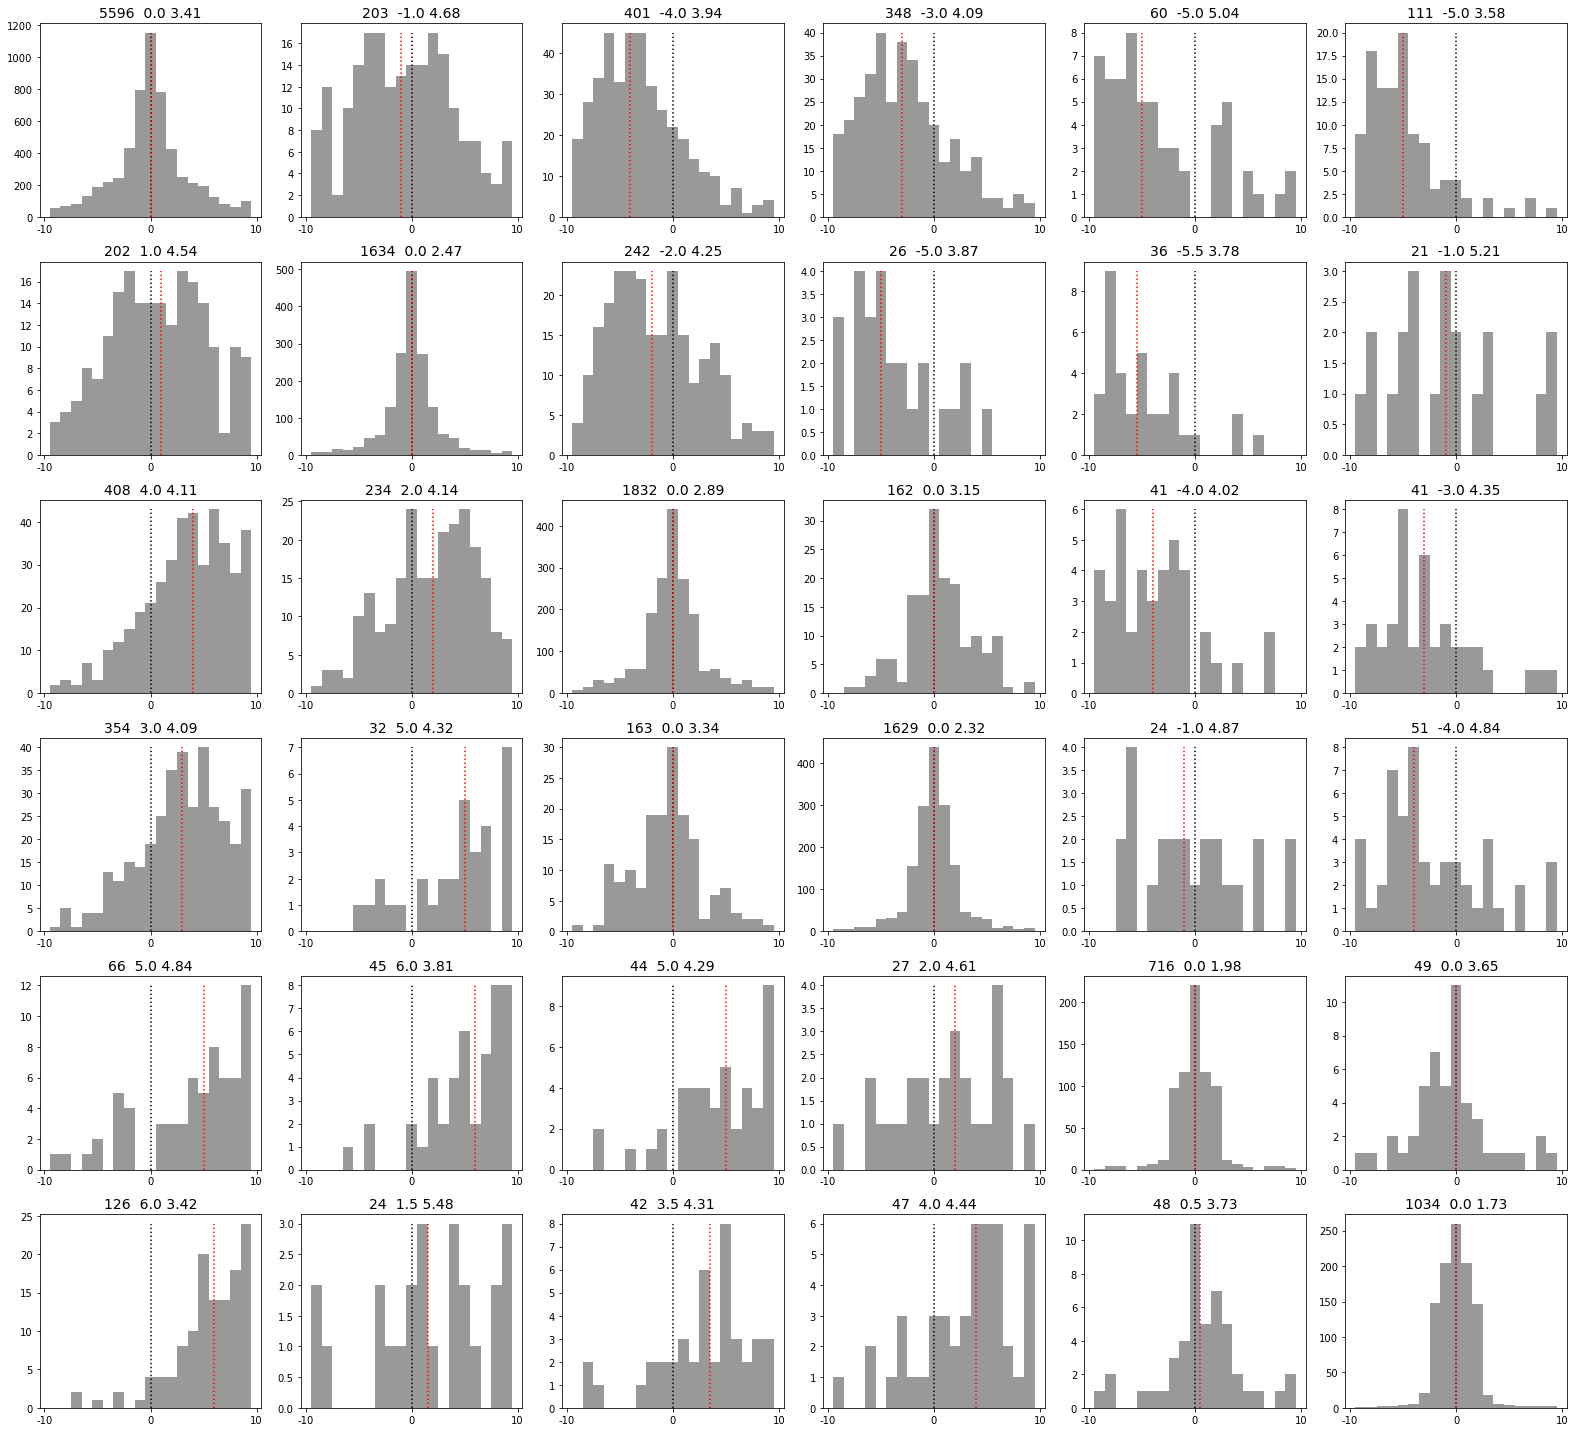

In [7]:
from scipy.stats import normaltest

plt.figure(figsize=(22,20))
N_connection=np.zeros((m,m))
M=np.zeros((m,m))
STD = np.zeros((m,m))
P = np.zeros((m,m))
for i in range(m):
    for j in range(m):
        ax1 = plt.subplot(m,m,i*m+j+1)
        a, bins, c = plt.hist(CCG_offset[i][j], bins=np.arange(-10,10,1), color='gray', alpha=0.8)
        s, p = normaltest(CCG_offset[i][j])
        P[i,j]=p
        plt.plot([-0.50,-0.50], [0, max(a)], ':k')
        md = round(np.nanmedian(CCG_offset[i][j]), 2)
        plt.plot([md+0.5,md+0.5], [0, max(a)], ':r')
        plt.xticks([-10.5,-0.5,9.5],[-10,0,10])
        plt.title(str(int(sum(a)))+'  '+str(md+1)+' '+str(round(np.std(CCG_offset[i][j]),2)), fontsize=14)
        STD[i,j]=round(np.std(CCG_offset[i][j]),2)
        N_connection[i,j]=sum(a)
        M[i,j]=md+1
plt.tight_layout()


In [8]:
tmp = np.tril(STD-np.diag(np.diag(STD)))
np.mean(tmp[tmp>0])

4.231333333333334

In [9]:
np.std(tmp[tmp>0])/np.sqrt(len(tmp[tmp>0]))

0.1358753241162784

In [11]:
# test normality with 20ms window
tmp = np.tril(P-np.diag(np.diag(P)))
tmp[tmp!=0]

array([2.68746071e-03, 4.74884138e-05, 5.95856654e-03, 1.33765219e-03,
       2.68311096e-01, 2.39547057e-01, 2.18349443e-02, 6.74459764e-03,
       7.45222017e-02, 5.15985331e-01, 3.33350518e-08, 5.97375219e-01,
       3.95824236e-02, 1.24814017e-01, 1.67945939e-01])

In [20]:
# direct statistics ‘Mann-Whitney’ test
from scipy.stats import mannwhitneyu, ranksums

print(mannwhitneyu(CCG_offset[2][1], CCG_offset[1][1]))
print(ranksums(CCG_offset[2][1], CCG_offset[1][1]))

MannwhitneyuResult(statistic=129609.0, pvalue=2.7286756219061085e-16)
RanksumsResult(statistic=7.978368978198819, pvalue=1.4827957299546331e-15)


# calculate the number of positive and negative connections, calculate index

In [24]:
m=6

FF_score=np.zeros((m,m))*np.NaN
for i in range(m):
    for j in range(m):
        tmp = np.array(CCG_offset[i][j])
        pos = np.where(tmp>-1)[0]
        neg = np.where(tmp<-1)[0]
        if len(pos)>0 or len(neg)>0:
            FF_score[i,j]=FF_index(len(pos), len(neg))
            
FF_score_b=np.zeros((m,m))*np.NaN
FF_score_std=np.zeros((m,m))*np.NaN
for i in range(m):
    for j in range(m):
        tmp = np.array(CCG_offset[i][j])
        pos = np.where(tmp>-1)[0]
        neg = np.where(tmp<-1)[0]
        if len(pos)>0 or len(neg)>0:
            miu, var = FF_index_bootstrapped(pos, neg)
            FF_score_b[i,j]=miu
            FF_score_std[i,j]=var
            

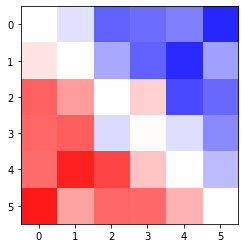

In [25]:
plt.imshow(FF_score, cmap='bwr', vmin=-1, vmax=1)

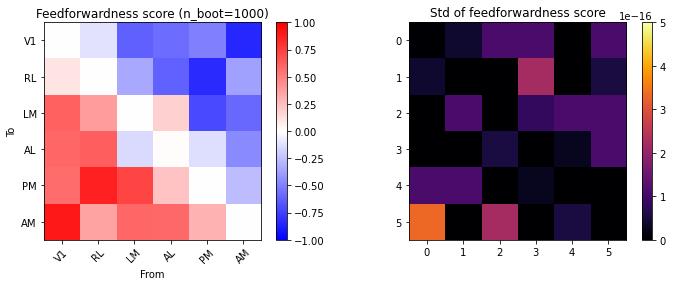

In [29]:
all_labels = ['V1', 'RL', 'LM','AL',  'PM', 'AM']
shift_index = [0,1,2,3,4,5]
current_cmap = plt.cm.get_cmap('bwr')
current_cmap.set_bad(color='gray')

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(FF_score_b[shift_index,:][:,shift_index], cmap='bwr', vmin=-1, vmax=1)
plt.xticks(range(6), all_labels, rotation = 45)
plt.yticks(range(6), all_labels)
plt.colorbar()
plt.title('Feedforwardness score (n_boot=1000)')
plt.xlabel('From')
plt.ylabel('To')

plt.subplot(122)
plt.imshow(FF_score_std[shift_index,:][:,shift_index], cmap='inferno',vmax=5e-16)
plt.title('Std of feedforwardness score')
plt.colorbar()


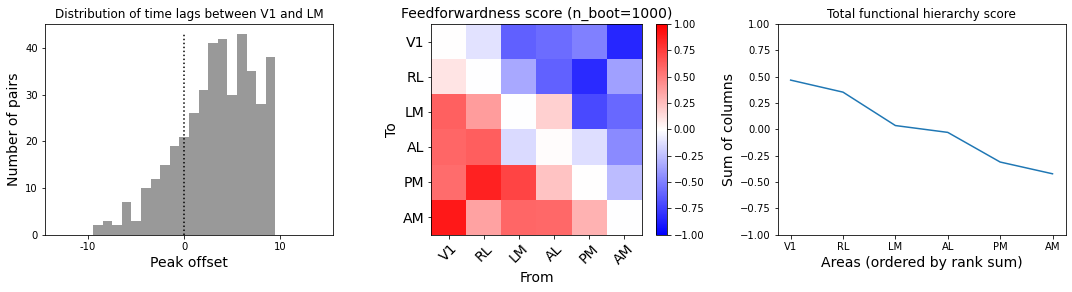

In [30]:
plt.figure(figsize=(15,4))
plt.subplot(131)
a, bins, c = plt.hist(CCG_offset[2][0], bins=np.arange(-10,10,1), color='gray', alpha=0.8)
#plt.title(areas_all[j]+'-'+areas_all[i], fontsize=15)
plt.plot([-0.50,-0.50], [0, max(a)], ':k')
plt.xticks([-10.5,-0.5,9.5],[-10,0,10])
plt.xlim([-15,15])
plt.xlabel('Peak offset', fontsize=14)
plt.ylabel('Number of pairs', fontsize=14)
plt.title('Distribution of time lags between V1 and LM')

plt.subplot(132)
all_labels = ['V1', 'RL', 'LM','AL',  'PM', 'AM']
shift_index = [0,1,2,3,4,5]
current_cmap = plt.cm.get_cmap('bwr')
current_cmap.set_bad(color='gray')
plt.imshow(FF_score_b[shift_index,:][:,shift_index], cmap='bwr', vmin=-1, vmax=1)
plt.xticks(range(6), all_labels, rotation = 45, fontsize=14)
plt.yticks(range(6), all_labels, fontsize=14)
plt.colorbar()
plt.title('Feedforwardness score (n_boot=1000)', fontsize=14)
plt.xlabel('From', fontsize=14)
plt.ylabel('To', fontsize=14)

plt.subplot(133)
plt.plot(all_labels, np.mean(FF_score, axis=0))
plt.xlabel('Areas (ordered by rank sum)', fontsize=14)
plt.ylabel('Sum of columns', fontsize=14)
plt.title('Total functional hierarchy score')
plt.ylim([-1,1])
plt.tight_layout()


In [31]:
max(np.mean(FF_score, axis=0))-min(np.mean(FF_score, axis=0))

0.8905823493690164

Text(0.5, 1.0, 'Distribution of time lags between V1 and LM')

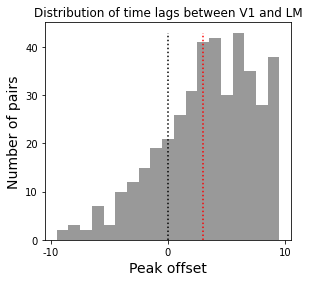

In [32]:
plt.figure(figsize=(15,4))
plt.subplot(131)
a, bins, c = plt.hist(CCG_offset[2][0], bins=np.arange(-10,10,1), color='gray', alpha=0.8)
#plt.title(areas_all[j]+'-'+areas_all[i], fontsize=15)
plt.plot([-0.50,-0.50], [0, max(a)], ':k')
plt.plot([np.nanmedian(CCG_offset[2][0])-0.50,np.nanmedian(CCG_offset[2][0])-0.50], [0, max(a)], ':r')
plt.xticks([-10.5,-0.5,9.5],[-10,0,10])
plt.xlim([-11,10])
plt.xlabel('Peak offset', fontsize=14)
plt.ylabel('Number of pairs', fontsize=14)
plt.title('Distribution of time lags between V1 and LM')


# simulate gaussian with different offset with the assumption of different network structure

## complete flat network

In [33]:
mu, sigma = 0, 4
s = np.random.normal(mu, sigma, 1000)

(-15.0, 15.0)

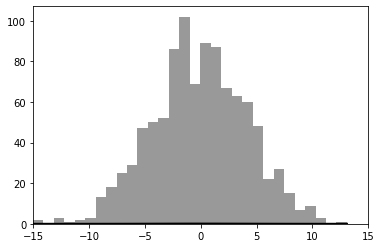

In [35]:
count, bins, ignored = plt.hist(s, 30,  color='gray', alpha=0.8)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='k')
plt.xlim([-15,15])

In [24]:
m=6
mu, sigma = 0, 4
s = np.random.normal(mu, sigma, 1000)

FF_score_null=np.zeros((m,m))
for i in range(m):
    for j in range(m):
        tmp = s
        pos = np.where(tmp>0.1)[0]
        neg = np.where(tmp<0.1)[0]
        FF_score_null[i,j]=FF_index(len(pos), len(neg))


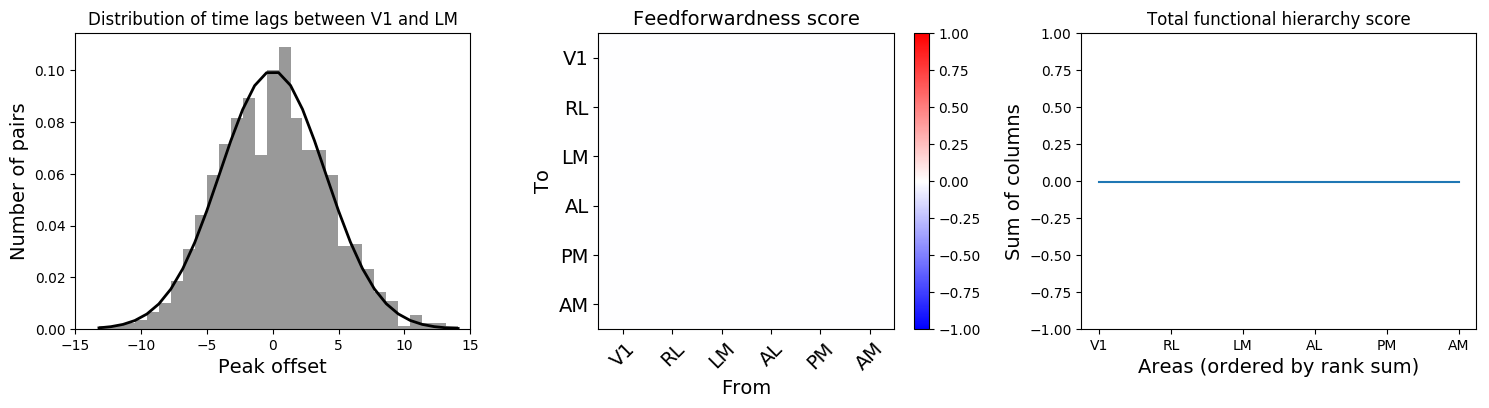

In [54]:

plt.figure(figsize=(15,4))
plt.subplot(131)
count, bins, ignored = plt.hist(s, 30, normed=True, color='gray', alpha=0.8)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='k')
plt.xlim([-15,15])

plt.xlabel('Peak offset', fontsize=14)
plt.ylabel('Number of pairs', fontsize=14)
plt.title('Distribution of time lags between V1 and LM')

plt.subplot(132)
all_labels = ['V1', 'RL', 'LM','AL',  'PM', 'AM']
shift_index = [0,1,2,3,4,5]
current_cmap = plt.cm.get_cmap('bwr')
current_cmap.set_bad(color='gray')
plt.imshow(FF_score_null, cmap='bwr', vmin=-1, vmax=1)
plt.xticks(range(6), all_labels, rotation = 45, fontsize=14)
plt.yticks(range(6), all_labels, fontsize=14)
plt.colorbar()
plt.title('Feedforwardness score', fontsize=14)
plt.xlabel('From', fontsize=14)
plt.ylabel('To', fontsize=14)

plt.subplot(133)
plt.plot(all_labels, np.mean(FF_score_null, axis=0))
plt.xlabel('Areas (ordered by rank sum)', fontsize=14)
plt.ylabel('Sum of columns', fontsize=14)
plt.title('Total functional hierarchy score')
plt.ylim([-1,1])
plt.tight_layout()

In [55]:
max(np.mean(FF_score_null, axis=0))-min(np.mean(FF_score_null, axis=0))

0.0

## V1 to all network

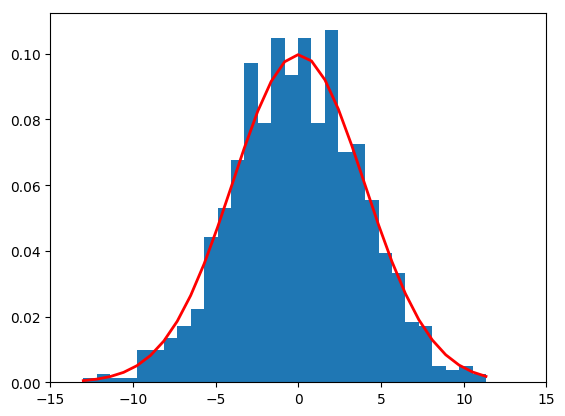

In [100]:
m=6
me, sigma = 1, 4
s1 = np.random.normal(mu, sigma, 1000)

count, bins, ignored = plt.hist(s1, 30, normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.xlim([-15,15])

FF_score_null=np.zeros((m,m))
for i in range(m):
    for j in range(m):
        if j==0 and i!=j:
            mu, sigma = me, 4
            tmp = np.random.normal(mu, sigma, 1000)
        elif i==0 and i!=j:
            mu, sigma = -me, 4
            tmp = np.random.normal(mu, sigma, 1000)
        else: 
            tmp=s
        pos = np.where(tmp>np.mean(s))[0]
        neg = np.where(tmp<np.mean(s))[0]
        FF_score_null[i,j]=FF_index(len(pos), len(neg))


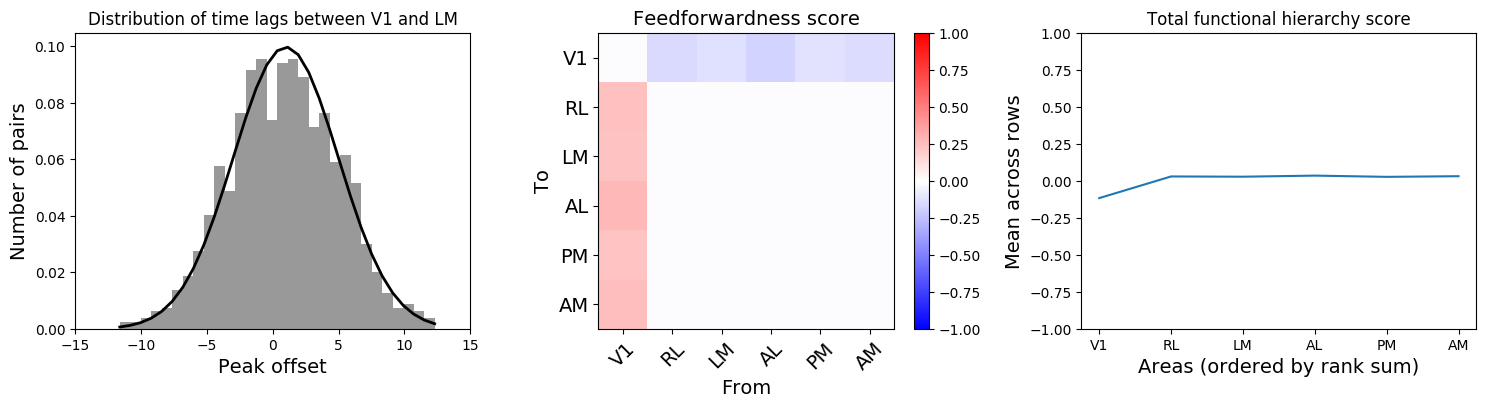

In [101]:


plt.figure(figsize=(15,4))

plt.subplot(131)
m=6
mu, sigma = 1, 4
s1 = np.random.normal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s1, 30, normed=True, color='gray', alpha=0.8)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='k')
plt.xlim([-15,15])

plt.xlabel('Peak offset', fontsize=14)
plt.ylabel('Number of pairs', fontsize=14)
plt.title('Distribution of time lags between V1 and LM')

plt.subplot(132)
all_labels = ['V1', 'RL', 'LM','AL',  'PM', 'AM']
shift_index = [0,1,2,3,4,5]
current_cmap = plt.cm.get_cmap('bwr')
current_cmap.set_bad(color='gray')
plt.imshow(FF_score_null, cmap='bwr', vmin=-1, vmax=1)
plt.xticks(range(6), all_labels, rotation = 45, fontsize=14)
plt.yticks(range(6), all_labels, fontsize=14)
plt.colorbar()
plt.title('Feedforwardness score', fontsize=14)
plt.xlabel('From', fontsize=14)
plt.ylabel('To', fontsize=14)

plt.subplot(133)
plt.plot(all_labels, np.mean(FF_score_null, axis=1))
plt.xlabel('Areas (ordered by rank sum)', fontsize=14)
plt.ylabel('Mean across rows', fontsize=14)
plt.title('Total functional hierarchy score')
plt.ylim([-1,1])
plt.tight_layout()


In [102]:
max(np.mean(FF_score_null, axis=1))-min(np.mean(FF_score_null, axis=1))

0.152

In [39]:
max(np.mean(FF_score_null, axis=1))-min(np.mean(FF_score_null, axis=1))

0.36466666666666664

# staircased

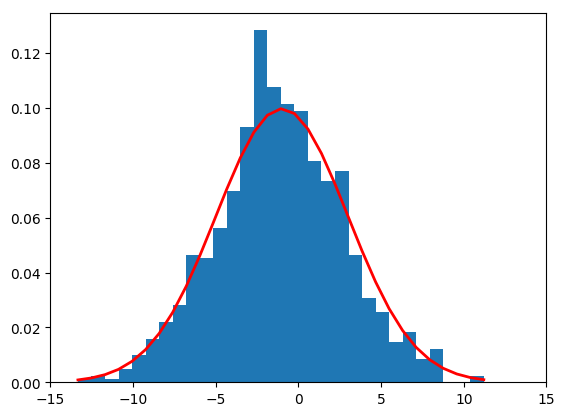

In [98]:
# V1 first layer, 
m=6
me, sigma = 1, 4
s1 = np.random.normal(mu, sigma, 1000)

count, bins, ignored = plt.hist(s1, 30, normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.xlim([-15,15])

FF_score_null=np.zeros((m,m))
for i in range(m):
    for j in range(m):
        if i!=j:
            if i==0:
                if j in [1,2,3]:
                    mu, sigma = me, 4
                    tmp = np.random.normal(mu, sigma, 1000)
                elif j in [4,5]:
                    mu, sigma = 2*me, 4
                    tmp = np.random.normal(mu, sigma, 1000)
            elif i in [1,2,3]:
                if j == 0:
                    mu, sigma = -me, 4
                    tmp = np.random.normal(mu, sigma, 1000)
                elif j in [1,2,3]:
                    mu, sigma = 0, 4
                    tmp = np.random.normal(mu, sigma, 1000)
                elif j in [4,5]:
                    mu, sigma = me, 4
                    tmp = np.random.normal(mu, sigma, 1000)
            elif i in [4,5]:
                if j==0:
                    mu, sigma = -2*me, 4
                    tmp = np.random.normal(mu, sigma, 1000)
                elif j in [1,2,3]:
                    mu, sigma = -me, 4
                    tmp = np.random.normal(mu, sigma, 1000)
                elif j in [4,5]:
                    mu, sigma = 0, 4
                    tmp = np.random.normal(mu, sigma, 1000)
        else: 
            tmp=s
        pos = np.where(tmp>0)[0]
        neg = np.where(tmp<0)[0]
        FF_score_null[j,i]=FF_index(len(pos), len(neg))

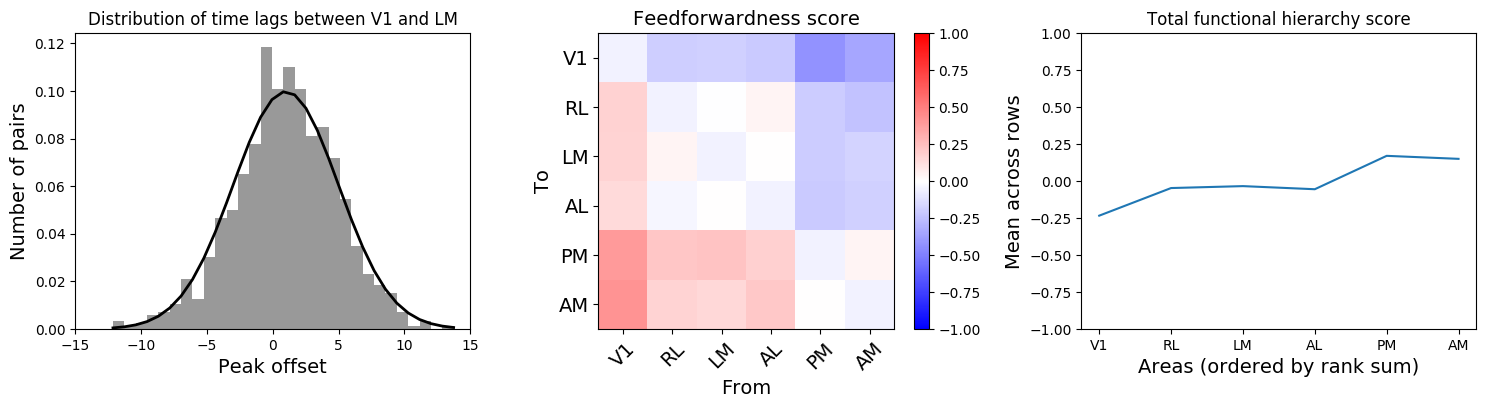

In [62]:
plt.figure(figsize=(15,4))
plt.subplot(131)
mu, sigma = 1, 4
s1 = np.random.normal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s1, 30, normed=True, color='gray', alpha=0.8)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='k')
plt.xlim([-15,15])

plt.xlabel('Peak offset', fontsize=14)
plt.ylabel('Number of pairs', fontsize=14)
plt.title('Distribution of time lags between V1 and LM')

plt.subplot(132)
all_labels = ['V1', 'RL', 'LM','AL',  'PM', 'AM']
shift_index = [0,1,2,3,4,5]
current_cmap = plt.cm.get_cmap('bwr')
current_cmap.set_bad(color='gray')
plt.imshow(FF_score_null, cmap='bwr', vmin=-1, vmax=1)
plt.xticks(range(6), all_labels, rotation = 45, fontsize=14)
plt.yticks(range(6), all_labels, fontsize=14)
plt.colorbar()
plt.title('Feedforwardness score', fontsize=14)
plt.xlabel('From', fontsize=14)
plt.ylabel('To', fontsize=14)

plt.subplot(133)
plt.plot(all_labels, np.mean(FF_score_null, axis=1))
plt.xlabel('Areas (ordered by rank sum)', fontsize=14)
plt.ylabel('Mean across rows', fontsize=14)
plt.title('Total functional hierarchy score')
plt.ylim([-1,1])
plt.tight_layout()


In [99]:
max(np.mean(FF_score_null, axis=1))-min(np.mean(FF_score_null, axis=1))

0.37433333333333335

In [54]:
max(np.mean(FF_score_null, axis=1))-min(np.mean(FF_score_null, axis=1))

0.7283333333333333

# pure hierarchical

In [96]:
FF_score_null=np.zeros((m,m))
for j in range(m):
    for i in range(m):
        if i!=j:
            mu, sigma = (i-j), 4
            s1 = np.random.normal(mu, sigma, 1000)
            tmp = s1
            pos = np.where(tmp>np.mean(s))[0]
            neg = np.where(tmp<np.mean(s))[0]
            FF_score_null[i,j]=FF_index(len(pos), len(neg))
        else:
            tmp=s
            pos = np.where(tmp>np.mean(s))[0]
            neg = np.where(tmp<np.mean(s))[0]
            FF_score_null[i,j]=FF_index(len(pos), len(neg))

In [93]:
np.mean(s)

-0.226788562784721

Text(0.5,1,'Feedforwardness score')

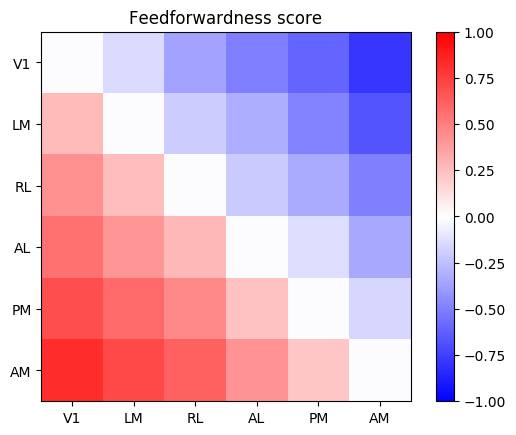

In [94]:
area_names = ['V1', 'LM', 'RL','AL',  'PM', 'AM']
plt.imshow(FF_score_null, cmap='bwr', vmin=-1, vmax=1)
plt.xticks(range(6), area_names)
plt.yticks(range(6), area_names)
plt.colorbar()
plt.title('Feedforwardness score')

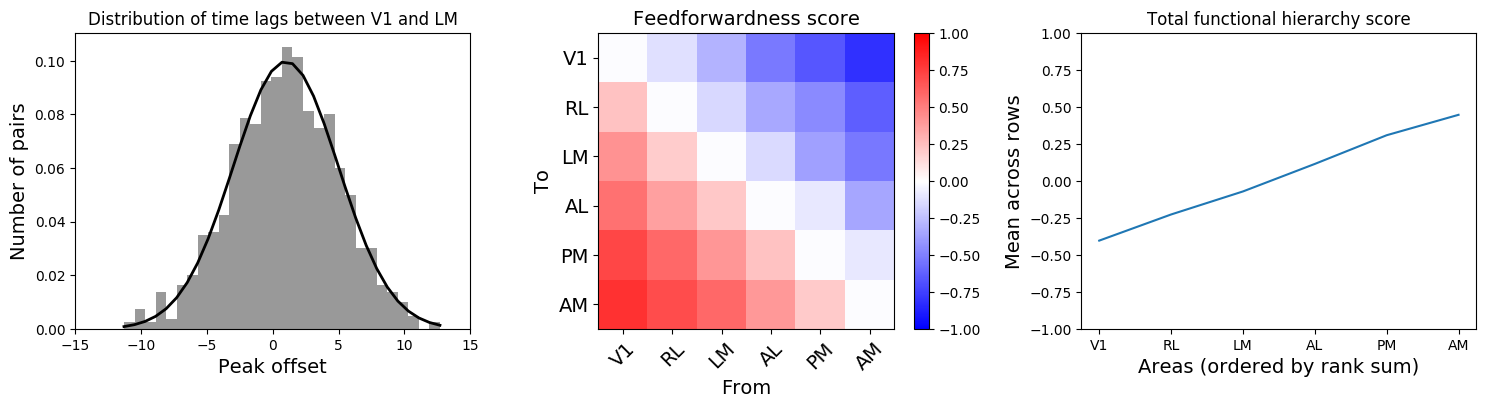

In [73]:
plt.figure(figsize=(15,4))
plt.subplot(131)
mu, sigma = 1, 4
s1 = np.random.normal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s1, 30, normed=True, color='gray', alpha=0.8)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='k')
plt.xlim([-15,15])

plt.xlabel('Peak offset', fontsize=14)
plt.ylabel('Number of pairs', fontsize=14)
plt.title('Distribution of time lags between V1 and LM')

plt.subplot(132)
all_labels = ['V1', 'RL', 'LM','AL',  'PM', 'AM']
shift_index = [0,1,2,3,4,5]
current_cmap = plt.cm.get_cmap('bwr')
current_cmap.set_bad(color='gray')
plt.imshow(FF_score_null, cmap='bwr', vmin=-1, vmax=1)
plt.xticks(range(6), all_labels, rotation = 45, fontsize=14)
plt.yticks(range(6), all_labels, fontsize=14)
plt.colorbar()
plt.title('Feedforwardness score', fontsize=14)
plt.xlabel('From', fontsize=14)
plt.ylabel('To', fontsize=14)

plt.subplot(133)
plt.plot(all_labels, np.mean(FF_score_null, axis=1))
plt.xlabel('Areas (ordered by rank sum)', fontsize=14)
plt.ylabel('Mean across rows', fontsize=14)
plt.title('Total functional hierarchy score')
plt.ylim([-1,1])
plt.tight_layout()


In [97]:
max(np.mean(FF_score_null, axis=1))-min(np.mean(FF_score_null, axis=1))

0.879

In [90]:
FF_score_null=np.zeros((m,m))
for j in range(m):
    for i in range(m):
        mu, sigma = (i-j), 1
        s1 = np.random.normal(mu, sigma, 1000)
        tmp = s1
        pos = np.where(tmp>0)[0]
        neg = np.where(tmp<0)[0]
        FF_score_null[i,j]=FF_index(len(pos), len(neg))


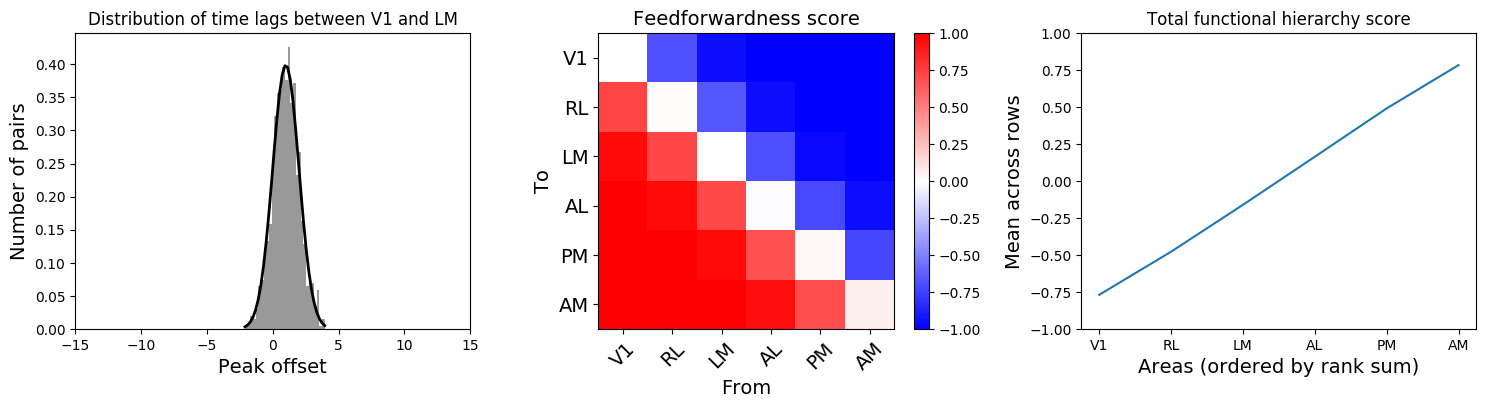

In [81]:
plt.figure(figsize=(15,4))
plt.subplot(131)
mu, sigma = 1, 1
s1 = np.random.normal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s1, 30, normed=True, color='gray', alpha=0.8)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='k')
plt.xlim([-15,15])

plt.xlabel('Peak offset', fontsize=14)
plt.ylabel('Number of pairs', fontsize=14)
plt.title('Distribution of time lags between V1 and LM')

plt.subplot(132)
all_labels = ['V1', 'RL', 'LM','AL',  'PM', 'AM']
shift_index = [0,1,2,3,4,5]
current_cmap = plt.cm.get_cmap('bwr')
current_cmap.set_bad(color='gray')
plt.imshow(FF_score_null, cmap='bwr', vmin=-1, vmax=1)
plt.xticks(range(6), all_labels, rotation = 45, fontsize=14)
plt.yticks(range(6), all_labels, fontsize=14)
plt.colorbar()
plt.title('Feedforwardness score', fontsize=14)
plt.xlabel('From', fontsize=14)
plt.ylabel('To', fontsize=14)

plt.subplot(133)
plt.plot(all_labels, np.mean(FF_score_null, axis=1))
plt.xlabel('Areas (ordered by rank sum)', fontsize=14)
plt.ylabel('Mean across rows', fontsize=14)
plt.title('Total functional hierarchy score')
plt.ylim([-1,1])
plt.tight_layout()


In [91]:
max(np.mean(FF_score_null, axis=0))-min(np.mean(FF_score_null, axis=0))

1.541